# Exploratory Data Analysis with a small subset of data
- Use a subset of major directors -> around 20
- subset those directors to their films
- subset ratings and etc
- need to explor incorporting OMDB to get the ratings and view various ranking systems on good films


#### Load Packages

In [1]:
import pandas as pd
import polars as pl
import numpy as np
import gzip
import pyarrow
import sys
from pathlib import Path
from tqdm import tqdm
import os


import matplotlib.pyplot as plt
import seaborn as sns
import sys
from pathlib import Path

sns.set_theme(style="darkgrid")

# Add the `src` folder to Python's search path
src_path = "/Users/bradkittrell/Projects/imdb/IMDB_Fun/src"
sys.path.append(src_path)

In [2]:
from data import generate_dataset
from features import build_features
import json

# Load the JSON file
with open("/Users/bradkittrell/Projects/imdb/IMDB_Fun/src/data/api_keys.json", "r") as json_file:
    config = json.load(json_file)

omdb_key = config['OMDB_API_KEY']

## Load Data and merge

In [3]:
# going to use imdbs list of top 25 directors of all time

names = generate_dataset.load_names(None)
film_crew = generate_dataset.load_crew(None)
films = generate_dataset.load_title_basics(None)

INFO:root:No path provided. Using default path: /Users/bradkittrell/Projects/imdb/IMDB_Fun/Data/processed/name.parquet
INFO:root:Successfully loaded data from /Users/bradkittrell/Projects/imdb/IMDB_Fun/Data/processed/name.parquet
INFO:root:Filtered names data to include only rows where birthYear > 1899
INFO:root:Dropped __index_level_0__ column
INFO:root:No path provided. Using default path: /Users/bradkittrell/Projects/imdb/IMDB_Fun/Data/processed/title_crew.parquet
INFO:root:Successfully loaded data from /Users/bradkittrell/Projects/imdb/IMDB_Fun/Data/processed/title_crew.parquet
INFO:root:No path provided. Using default path: /Users/bradkittrell/Projects/imdb/IMDB_Fun/Data/processed/title_basics_movies.parquet
INFO:root:Successfully loaded data from /Users/bradkittrell/Projects/imdb/IMDB_Fun/Data/processed/title_basics_movies.parquet
INFO:root:Dropped __index_level_0__ column


In [4]:
films.head()

tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
str,str,str,str,i64,i64,i64,i64,str
"""tt0011801""","""movie""","""Tötet nicht mehr""","""Tötet nicht mehr""",0,2019,0,0,"""Action,Crime"""
"""tt0013274""","""movie""","""Istoriya grazhdanskoy voyny""","""Istoriya grazhdanskoy voyny""",0,2021,0,94,"""Documentary"""
"""tt0015414""","""movie""","""La tierra de los toros""","""La tierra de los toros""",0,2000,0,60,"""\N"""
"""tt0015724""","""movie""","""Dama de noche""","""Dama de noche""",0,1993,0,102,"""Drama,Mystery,Romance"""
"""tt0022064""","""movie""","""Lebbra bianca""","""Lebbra bianca""",0,1951,0,80,"""Drama"""


In [13]:
# # count director based on film appearance. This should help get a clean list of directors
import fileinput


dir_counts = films.join(film_crew, on="tconst").filter(
    (pl.col("runtimeMinutes") > 60) & (pl.col("runtimeMinutes") < 60*5)).group_by("directors").agg(pl.col('directors').count().alias('num_films'))
dir_counts = dir_counts.join(names, left_on="directors", right_on="nconst")

dir_counts = dir_counts.filter(pl.col("num_films") > 10)

films_with_dirs = films.join(film_crew, on="tconst").filter(
    (pl.col("runtimeMinutes") > 60) & (pl.col("runtimeMinutes") < 60*5)).filter(
    pl.col("directors").is_in(dir_counts['directors'].to_list()))
films_with_dirs = films_with_dirs.join(
    dir_counts, left_on="directors", right_on="directors")

films_with_dirs

dir_counts.select(
    ["directors", "num_films", "primaryName", "birthYear", "deathYear"]).filter(pl.col("num_films") > 10).with_columns(pl.col("directors").alias("nconst")).drop("directors")

num_films,primaryName,birthYear,deathYear,nconst
u32,str,i64,i64,str
31,"""Ingmar Bergman""",1918,2007,"""nm0000005"""
18,"""Federico Fellini""",1920,1993,"""nm0000019"""
12,"""Stanley Kubrick""",1928,1999,"""nm0000040"""
17,"""Akira Kurosawa""",1910,1998,"""nm0000041"""
21,"""François Truffaut""",1932,1984,"""nm0000076"""
…,…,…,…,…
11,"""Hirobumi Watanabe""",1982,0,"""nm6128510"""
12,"""Brando Improta""",1990,0,"""nm6199897"""
14,"""Özgür Bakar""",1982,0,"""nm6356309"""


In [182]:
films.join(film_crew, on="tconst").filter(
    (pl.col("runtimeMinutes") > 60) & (pl.col("runtimeMinutes") < 60*5)).head()

tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,directors,writers
str,str,str,str,i64,i64,i64,i64,str,str,str
"""tt0015724""","""movie""","""Dama de noche""","""Dama de noche""",0,1993,0,102,"""Drama,Mystery,Romance""","""nm0529960""","""nm0529960,nm1597742"""
"""tt0022064""","""movie""","""Lebbra bianca""","""Lebbra bianca""",0,1951,0,80,"""Drama""","""nm0871077""","""nm0871077,nm0872689"""
"""tt0025557""","""movie""","""El negro que tenía el alma bla…","""El negro que tenía el alma bla…",0,1951,0,87,"""Drama,Musical""","""nm0140459""","""nm0017046,nm0273236,nm0409404,…"
"""tt0030998""","""movie""","""You're Only Young Twice""","""You're Only Young Twice""",0,1952,0,81,"""Comedy""","""nm0084204""","""nm0108833,nm0303194,nm0065888,…"
"""tt0031603""","""movie""","""Made in Germany - Die dramatis…","""Made in Germany""",0,1957,0,97,"""Biography,Drama""","""nm0772191""","""nm0530752,nm0726114"""


In [6]:

top_n_directors = ["Steven Spielberg", "Martin Scorsese", "Alfred Hitchcock", "Roman Polanksi",
                   "John Ford", "Billy Wilder", "James Cameron", "Tim Burton", "Ridley Scott", "Joel Coen", "David Fincher",
                   "Christopher Nolan", "Clint Eastwood", "David Lean", "Woody Allen", "Stanley Kubrick", "Danny Boyle", "George Lucas", "Peter Jackson", "Quentin Tarantino",
                   "Fancis Ford Coppola"]
# lots of duplicate names or same names rather
top_n_directors_names = names.filter((pl.col("primaryName").is_in(
    top_n_directors)) & (pl.col("nconst") != "nm13407303") & (pl.col("nconst") != "nm0131607") & (pl.col("nconst") != "nm0131609") & (pl.col("nconst") != "nm7812401"))[["nconst", "primaryName"]]

top_n_directors_names


film_crew = film_crew.filter(
    pl.col("directors").is_in(top_n_directors_names["nconst"]))

top_n_directors_names_films = film_crew.join(top_n_directors_names, left_on="directors",
                                             right_on="nconst", how="inner")[["tconst", "primaryName"]]

top_n_directors_names_films = top_n_directors_names_films.join(
    films, on="tconst")

In [35]:
test = generate_dataset.fetch_movie_data("tt0025557",   api_key="95497563")

In [178]:
films_with_dirs['tconst'].to_list()

['tt0025557',
 'tt0030998',
 'tt0031603',
 'tt0032787',
 'tt0034683',
 'tt0035423',
 'tt0036247',
 'tt0036606',
 'tt0038020',
 'tt0038240',
 'tt0039442',
 'tt0039965',
 'tt0040258',
 'tt0040559',
 'tt0041357',
 'tt0041596',
 'tt0041688',
 'tt0041979',
 'tt0042215',
 'tt0042222',
 'tt0042227',
 'tt0042246',
 'tt0042254',
 'tt0042257',
 'tt0042269',
 'tt0042297',
 'tt0042305',
 'tt0042308',
 'tt0042309',
 'tt0042316',
 'tt0042346',
 'tt0042347',
 'tt0042386',
 'tt0042388',
 'tt0042407',
 'tt0042411',
 'tt0042413',
 'tt0042429',
 'tt0042434',
 'tt0042446',
 'tt0042454',
 'tt0042462',
 'tt0042465',
 'tt0042478',
 'tt0042479',
 'tt0042499',
 'tt0042503',
 'tt0042516',
 'tt0042558',
 'tt0042566',
 'tt0042571',
 'tt0042590',
 'tt0042601',
 'tt0042605',
 'tt0042619',
 'tt0042621',
 'tt0042626',
 'tt0042649',
 'tt0042660',
 'tt0042672',
 'tt0042675',
 'tt0042704',
 'tt0042717',
 'tt0042737',
 'tt0042756',
 'tt0042760',
 'tt0042781',
 'tt0042803',
 'tt0042839',
 'tt0042842',
 'tt0042851',
 'tt00

In [14]:
import re
from sys import api_version
import requests

# top5 = top_n_directors_names_films['tconst'].to_list()


# generate_dataset.fetch_movie_data(imdb_film_id=top5[0], api_key="95497563")
generate_dataset.process_omdb_ids(
    api_key=omdb_key, imdb_ids=films_with_dirs['tconst'].to_list())

# url = f"http://www.omdbapi.com/?i=tt0025557&plot=full&apikey=95497563"
# response = requests.get(url)

# response

INFO:root:No path provided. Using default path: /Users/bradkittrell/Projects/imdb/IMDB_Fun/Data/external/omdb.csv
INFO:root:No path provided. Using default path: /Users/bradkittrell/Projects/imdb/IMDB_Fun/Data/external/omdb.csv


Updated cache with 10 new entries.
Updated cache with 20 new entries.
Updated cache with 30 new entries.
Updated cache with 40 new entries.
Updated cache with 50 new entries.
Updated cache with 60 new entries.
Updated cache with 70 new entries.
Updated cache with 80 new entries.
Updated cache with 90 new entries.
Updated cache with 100 new entries.
Updated cache with 110 new entries.
Updated cache with 120 new entries.
Updated cache with 130 new entries.
Updated cache with 140 new entries.
Updated cache with 150 new entries.
Updated cache with 160 new entries.
Updated cache with 170 new entries.
Updated cache with 180 new entries.
Updated cache with 190 new entries.
Updated cache with 200 new entries.
Updated cache with 210 new entries.
Updated cache with 220 new entries.
Updated cache with 230 new entries.
Updated cache with 240 new entries.
Updated cache with 250 new entries.
Updated cache with 260 new entries.
Updated cache with 270 new entries.
Updated cache with 280 new entries.
U

ERROR:root:Failed to fetch data for tt0052906
ERROR:root:Failed to fetch data for tt0052910
ERROR:root:Failed to fetch data for tt0052912
ERROR:root:Failed to fetch data for tt0052913
ERROR:root:Failed to fetch data for tt0052914
ERROR:root:Failed to fetch data for tt0052915
ERROR:root:Failed to fetch data for tt0052920
ERROR:root:Failed to fetch data for tt0052921
ERROR:root:Failed to fetch data for tt0052922
ERROR:root:Failed to fetch data for tt0052923
ERROR:root:Failed to fetch data for tt0052925
ERROR:root:Failed to fetch data for tt0052926
ERROR:root:Failed to fetch data for tt0052928
ERROR:root:Failed to fetch data for tt0052933
ERROR:root:Failed to fetch data for tt0052938
ERROR:root:Failed to fetch data for tt0052944
ERROR:root:Failed to fetch data for tt0052948
ERROR:root:Failed to fetch data for tt0052951
ERROR:root:Failed to fetch data for tt0052953
ERROR:root:Failed to fetch data for tt0052955
ERROR:root:Failed to fetch data for tt0052957
ERROR:root:Failed to fetch data fo

,Title,Year,Rated,Released,Runtime,Genre,Director,Writer,Actors,Plot,...,imdbVotes,imdbID,Type,DVD,BoxOffice,Production,Website,Response,RatingSource,RatingValue
0,Once Upon a Time... in Hollywood,2019,R,26 Jul 2019,161 min,"Comedy, Drama",Quentin Tarantino,Quentin Tarantino,"Leonardo DiCaprio, Brad Pitt, Margot Robbie",Quentin Tarantino's Once Upon a Time... in Hol...,...,"882,682",tt7131622,movie,NaN,"$142,502,728",NaN,NaN,True,Internet Movie Database,7.6/10
1,Once Upon a Time... in Hollywood,2019,R,26 Jul 2019,161 min,"Comedy, Drama",Quentin Tarantino,Quentin Tarantino,"Leonardo DiCaprio, Brad Pitt, Margot Robbie",Quentin Tarantino's Once Upon a Time... in Hol...,...,"882,682",tt7131622,movie,NaN,"$142,502,728",NaN,NaN,True,Rotten Tomatoes,86%
2,Once Upon a Time... in Hollywood,2019,R,26 Jul 2019,161 min,"Comedy, Drama",Quentin Tarantino,Quentin Tarantino,"Leonardo DiCaprio, Brad Pitt, Margot Robbie",Quentin Tarantino's Once Upon a Time... in Hol...,...,"882,682",tt7131622,movie,NaN,"$142,502,728",NaN,NaN,True,Metacritic,84/100
3,Ace in the Hole,1951,Approved,04 Jul 1951,111 min,"Drama, Film-Noir",Billy Wilder,"Billy Wilder, Lesser Samuels, Walter Newman","Kirk Douglas, Jan Sterling, Robert Arthur","Charles Tatum, a down-on-his-luck reporter, ta...",...,"40,295",tt0043338,movie,NaN,NaN,NaN,NaN,True,Internet Movie Database,8.1/10
4,Ace in the Hole,1951,Approved,04 Jul 1951,111 min,"Drama, Film-Noir",Billy Wilder,"Billy Wilder, Lesser Samuels, Walter Newman","Kirk Douglas, Jan Sterling, Robert Arthur","Charles Tatum, a down-on-his-luck reporter, ta...",...,"40,295",tt0043338,movie,NaN,NaN,NaN,NaN,True,Rotten Tomatoes,90%
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5146,Gundown at Sandoval,1961,N/A,26 Mar 1961,72 min,Western,Harry Keller,"Frank D. Gilroy, Maurice Tombragel","Tom Tryon, John Alderson, Lyle Bettger",N/A,...,28,tt0052868,movie,N/A,N/A,N/A,N/A,True,Internet Movie Database,6.9/10
5147,Habanera,1961,N/A,N/A,90 min,"Comedy, Drama, Musical",José María Elorrieta,"José María Elorrieta, Manuel Sebares","Lolita Sevilla, Virgilio Teixeira, Antonio Casas","Rosa María, whose father lives in Cuba, was se...",...,14,tt0052872,movie,N/A,N/A,N/A,N/A,True,Internet Movie Database,5.8/10
5148,Happy Anniversary,1959,Not Rated,24 Mar 1960,83 min,Comedy,David Miller,"Joseph Fields, Jerome Chodorov","David Niven, Mitzi Gaynor, Carl Reiner",Living in the Gramercy Park neighborhood of Ne...,...,306,tt0052878,movie,N/A,N/A,N/A,N/A,True,Internet Movie Database,5.8/10
5149,Have Rocket -- Will Travel,1959,N/A,01 Aug 1959,76 min,"Comedy, Family, Sci-Fi",David Lowell Rich,Raphael Hayes,"Moe Howard, Larry Fine, Joe DeRita",The 3 Stooges are cleaners at a spaceport when...,...,"1,022",tt0052880,movie,N/A,N/A,N/A,N/A,True,Internet Movie Database,5.6/10


INFO:root:No path provided. Using default path: /Users/bradkittrell/Projects/imdb/IMDB_Fun/Data/external/omdb.csv


Ratings Sources: 
RatingSource
Internet Movie Database    3247
Rotten Tomatoes             614
Metacritic                  361
Name: count, dtype: int64


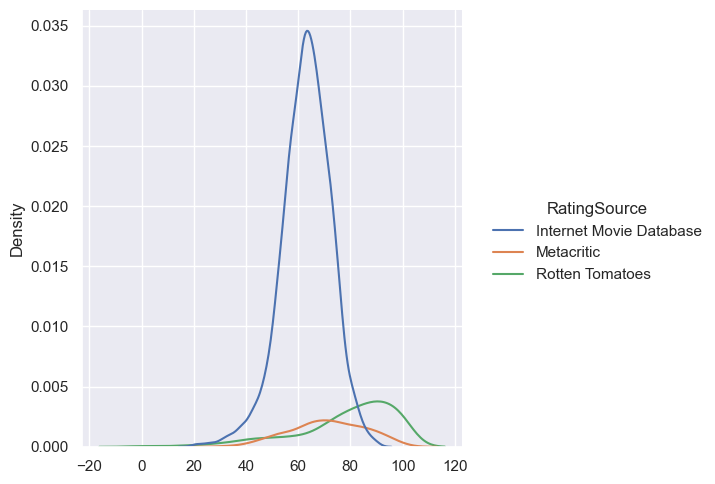

<Axes: xlabel='RatingSource', ylabel='RatingSource'>

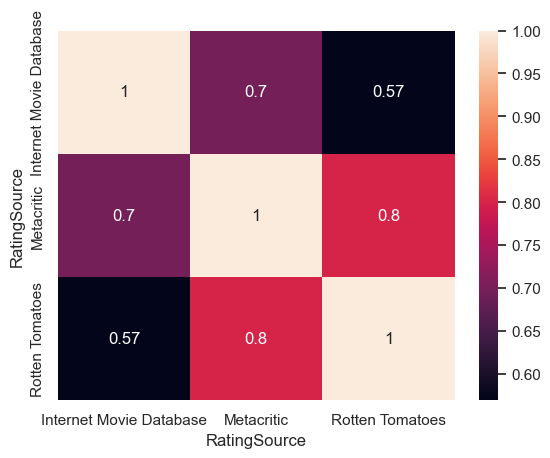

In [12]:
film_data = generate_dataset.load_cached_omdb_data(None)
# one question I have is on ratings lets get them all on the same scale
print(f"Ratings Sources: \n{film_data['RatingSource'].value_counts()}")


def convert_rating(rating, source):
    """_summary_
    Converts ratings from various sources to a common scale. used in a lambda function
    Args:
        rating (_type_): _description_
        source (_type_): _description_

    Returns:
        _type_: _description_
    """
    if source == "Internet Movie Database":
        return float(rating.split("/")[0])*10
    elif source == "Rotten Tomatoes":
        return float(rating.replace("%", ""))
    elif source == "Metacritic":
        return float(rating.split("/")[0])
    else:
        return float(rating)


film_data['RatingValueNumeric'] = film_data.apply(lambda x: convert_rating(
    x["RatingValue"], x["RatingSource"]), axis=1)

ratings_wide = film_data[['RatingValueNumeric', 'RatingSource', 'imdbID']].pivot(
    columns='RatingSource', values='RatingValueNumeric', index='imdbID')

sns.displot(ratings_wide, kind="kde")
plt.show()

sns.heatmap(ratings_wide.corr(), annot=True)

In [7]:
top_n_directors_names_ratings = top_n_directors_names_films.join(pl.from_pandas(
    ratings_wide.reset_index()), left_on="tconst", right_on="imdbID", how="inner")

top_n_directors_names_ratings = top_n_directors_names_ratings.join(pl.from_pandas(
    film_data[['imdbID', 'BoxOffice', 'Released']].drop_duplicates()), left_on="tconst", right_on="imdbID", how="inner")

mean_director_metacritic = top_n_directors_names_ratings.group_by(
    "primaryName").agg(pl.col("Metacritic").mean())

top_n_directors_names_ratings = top_n_directors_names_ratings.with_columns(
    pl.col("Released").str.to_datetime("%d %b %Y").alias("Released")).drop_nulls()
sns.barplot(mean_director_metacritic.sort("Metacritic", descending=True), y="primaryName",
            x="Metacritic", orient="h")
plt.show()

NameError: name 'top_n_directors_names_films' is not defined

In [11]:

from plotly import express as px

top_n_directors_names_ratings = top_n_directors_names_ratings.with_columns(
    pl.col("Released").dt.year().alias("ReleasedYear"))

top_n_directors_names_ratings_time = top_n_directors_names_ratings.group_by("ReleasedYear", "primaryName").agg(
    pl.col("Metacritic").mean()).sort("ReleasedYear")


fig = px.line(top_n_directors_names_ratings_time.to_pandas(),
              x="ReleasedYear",
              y="Metacritic",
              color="primaryName",
              title="Director's Metacritic Scores Over Time",
              labels={"Metacritic": "Metacritic Score",
                      "ReleasedYear": "Release Year"}
              )

# Add interactive hover and selection
fig.update_traces(hoverinfo="x+y+name", mode="lines+markers")
# fig.update_layout(
#     width=900,  # Set width (in pixels)
#     height=600  # Set height (in pixels)
# )
# Set layout to highlight selection
fig.update_layout(
    legend_title="Directors",
    hovermode="x unified",
    title_x=0.5,
    height=600,
    legend=dict(
        title="Select Director",
        itemsizing="constant"
    )
)

# Show the plot
fig.show()

In [12]:
cpi_data = pl.read_csv(
    "/Users/bradkittrell/Projects/imdb/IMDB_Fun/Data/external/CPILFENS.csv")
cpi_data = cpi_data.with_columns(
    pl.col("observation_date").str.strptime(pl.Date, "%Y-%m-%d"))

cpi_data.head()

observation_date,CPILFENS
date,f64
1957-01-01,28.5
1957-02-01,28.5
1957-03-01,28.7
1957-04-01,28.8
1957-05-01,28.8


In [13]:
film_data["Year"].min()

'1951'

In [19]:
from polars import col


oscars = pd.read_csv(
    "/Users/bradkittrell/Projects/imdb/IMDB_Fun/Data/external/oscars.csv", delimiter='\t', engine="python")


oscars_groupby_by_film = oscars[oscars['Ceremony'] > 23].groupby(["Film", "Year"]).agg({"Class": "count",
                                                                                        "Winner": "sum"}).reset_index()
oscars_groupby_by_film.rename(
    columns={"Class": "Nominations"}, inplace=True)
oscars_groupby_by_film['Winner'] = oscars_groupby_by_film['Winner'].fillna(
    0).astype(int)
oscars_groupby_by_film.head()
oscars_groupby_by_film

,Film,Year,Nominations,Winner
0,'38',1986,1,0
1,'Crocodile' Dundee,1986,1,0
2,'Round Midnight,1986,2,1
3,(A) Torzija [(A) Torsion],2003,1,0
4,...And Justice for All,1979,2,0
...,...,...,...,...
3881,the accountant,2001,1,1
3882,the end,1995,1,0
3883,"tick, tick...BOOM!",2021,2,0
3884,Ådalen '31,1969,1,0


In [12]:
elo_dataset.at[row.Index, 'elo']

NameError: name 'elo_dataset' is not defined

# ELO Directors

In [14]:
elo_dataset = film_data[["Title", "Year", "Director"]].drop_duplicates().merge(oscars_groupby_by_film,
                                                                               left_on=[
                                                                                   "Title", "Year"],
                                                                               right_on=["Film", "Year"])

elo_dataset['elo'] = 1500

# Function to calculate ELO adjustments based on awards


def update_elo(person_id, nominations, wins, current_elo, competitors):
    k_factor = 32  # Adjust impact size of changes

    # Adjust for nominations (small boost)
    nomination_bonus = 10 * nominations  # Each nomination gives a small boost

    # Adjust for wins (bigger boost)
    win_bonus = 50 * wins  # Winning an award carries more weight

    # Adjust based on competition strength (ELO difference matters)
    avg_competitor_elo = np.mean(
        [competitors.get(cid, 1500) for cid in competitors])
    expected_score = 1 / (1 + 10 ** ((avg_competitor_elo - current_elo) / 400))

    # Final ELO adjustment
    new_elo = current_elo + k_factor * \
        (win_bonus + nomination_bonus - expected_score * k_factor)
    return round(new_elo, 2)


# Simulate ELO adjustments over an award season
competitor_elos = {row.Director: row.elo for row in elo_dataset.itertuples()}

for row in elo_dataset.itertuples():
    person_id = row.Director
    nominations = row.Nominations
    wins = row.Winner
    current_elo = row.elo

    # Update ELO
    new_elo = update_elo(person_id, nominations, wins,
                         current_elo, competitor_elos)
    elo_dataset.at[row.Index, 'elo'] = new_elo

# # Display updated ELO scores
# import ace_tools as tools
# tools.display_dataframe_to_user(name="Updated ELO Rankings", dataframe=people_data)

### Better ELO dataset
- need to have a way to normalize data year to year
- include start year for director and last film date for director to have a decay effect
- count of films directed for that year

INFO:root:No path provided. Using default path: /Users/bradkittrell/Projects/imdb/IMDB_Fun/Data/processed/name.parquet
INFO:root:Successfully loaded data from /Users/bradkittrell/Projects/imdb/IMDB_Fun/Data/processed/name.parquet
INFO:root:Filtered names data to include only rows where birthYear > 1899
INFO:root:Dropped __index_level_0__ column


<Axes: xlabel='year'>

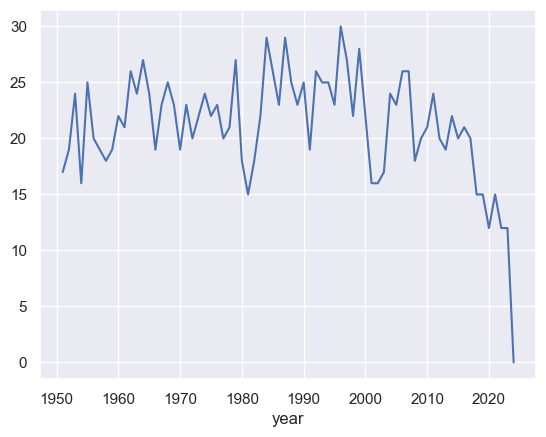

In [ ]:
directors_yrly = build_features.normalized_yearly_directors(start_year=1950,
                                                            end_year=2024,

                                                            director_ids=dir_counts['directors'].to_list())

# films_with_dirs = films_with_dirs.to_pandas()
films_with_dirs['Title_lower'] = films_with_dirs['originalTitle'].str.lower(
).str.replace(" ", "")
films_with_dirs['startYear'] = films_with_dirs['startYear'].astype(str)
oscars_groupby_by_film['Film_lower'] = oscars_groupby_by_film['Film'].str.lower(
).str.replace(" ", "")

film_data_oscars = films_with_dirs.merge(oscars_groupby_by_film, left_on=["Title_lower", "startYear"],
                                         right_on=["Film_lower", "Year"], how="left")[["originalTitle", "startYear", "directors", "Film", "Nominations", "Winner"]].reset_index(drop=True)
film_data_oscars['startYear'] = film_data_oscars['startYear'].astype(int)

directors_yrly_data = directors_yrly.to_pandas().merge(film_data_oscars, left_on=["year", "nconst"], right_on=[
    "startYear", "directors"], how="left")

dirs_min_max_year = directors_yrly_data.groupby(
    "directors").agg({"year": ["min", "max"]}).reset_index()

directors_yrly_data = directors_yrly_data.groupby(["director", "nconst", "year"]).agg(
    {"Film": "count", "Nominations": "sum", "Winner": "sum"}).reset_index()

dirs_min_max_year.columns = ['_'.join(col).strip()
                             for col in dirs_min_max_year.columns.values]
directors_yrly_data = directors_yrly_data.merge(
    dirs_min_max_year, left_on="nconst", right_on="directors_", how="left")
directors_yrly_data = directors_yrly_data[(directors_yrly_data['year'] >= directors_yrly_data['year_min']) & (
    directors_yrly_data['year'] <= directors_yrly_data['year_max'])]

In [122]:
from hmac import new


def update_elo_with_decay(person_id, nominations, wins, current_elo, competitors, last_active_year, current_year):
    if current_elo > 2000:
        k_factor = 2
    else:
        k_factor = 16  # Adjust impact size of changes

    # Adjust for nominations (small boost)
    nomination_bonus = 1 * nominations

    # Adjust for wins (bigger boost)
    win_bonus = 5 * wins

    # Adjust based on competition strength (ELO difference matters)
    avg_competitor_elo = np.mean(
        [competitors.get(cid, 1500) for cid in competitors if cid != person_id])
    # print(avg_competitor_elo)
    expected_score = 1 / \
        (1 + (10 ** ((avg_competitor_elo - current_elo) / 200)))

    # Time decay: Penalize inactivity over years
    years_inactive = max(0, current_year - last_active_year)
    decay_factor = 0.98 ** years_inactive  # 2% decay per inactive year

    # Final ELO adjustment
    new_elo = current_elo + k_factor * \
        (win_bonus + nomination_bonus - expected_score * k_factor)

    # Apply decay factor
    new_elo *= decay_factor

    return round(new_elo, 2)


directors_yrly_data['elo'] = 1500

years = sorted(directors_yrly_data['year'].unique())
# simulate ELO adjustments over an award season

# for year in years:
#     year_ = directors_yrly_data[directors_yrly_data['year'] == year]
#     # competitor_elos
#     previous_year = directors_yrly_data[directors_yrly_data['year'] == year - 1]
#     competitor_elos = {
#         row.director: row.elo for row in year_.itertuples()}

#     for row in year_.itertuples():
#         person_id = row.director
#         nominations = row.Nominations
#         wins = row.Winner
#         if len(directors_yrly_data[(directors_yrly_data['director'] == person_id) & (
#                 directors_yrly_data['year'] == year-1)]) == 0:
#             current_elo = 1500
#         else:
#             current_elo = directors_yrly_data[(directors_yrly_data['director'] == person_id) & (
#                 directors_yrly_data['year'] == year-1)]['elo'].values[0]
#         last_active = directors_yrly_data[(directors_yrly_data['director'] == person_id) & (
#             directors_yrly_data['year'] <= year) & (directors_yrly_data['Film'] > 0)]['year'].max()

#     # Update ELO
#         new_elo = update_elo_with_decay(person_id, nominations, wins,
#                                         current_elo, competitor_elos, last_active, year)
#         directors_yrly_data.at[row.Index, 'elo'] = new_elo

directors_yrly_data.head()

,director,nconst,deathYear,birthYear,year,originalTitle,startYear,directors,Film,Nominations,Winner,directors_,year_min,year_max,elo
1,Ingmar Bergman,nm0000005,2007,1918,1951,Sommarlek,1951.0,nm0000005,NaN,NaN,NaN,nm0000005,1951.0,2003.0,1500
2,Ingmar Bergman,nm0000005,2007,1918,1952,Kvinnors väntan,1952.0,nm0000005,NaN,NaN,NaN,nm0000005,1951.0,2003.0,1500
3,Ingmar Bergman,nm0000005,2007,1918,1953,Gycklarnas afton,1953.0,nm0000005,NaN,NaN,NaN,nm0000005,1951.0,2003.0,1500
4,Ingmar Bergman,nm0000005,2007,1918,1953,Sommaren med Monika,1953.0,nm0000005,NaN,NaN,NaN,nm0000005,1951.0,2003.0,1500
5,Ingmar Bergman,nm0000005,2007,1918,1954,En lektion i kärlek,1954.0,nm0000005,NaN,NaN,NaN,nm0000005,1951.0,2003.0,1500


In [ ]:


# film_d.merge(oscars_groupby_by_film, left_on="Title",
#                 right_on="Film", how="left")

# connect oscar data to film data
# TODO I need ot verify how many of the films i'm dropping
film_data['Title_lower'] = film_data['Title'].str.lower().str.replace(" ", "")
oscars_groupby_by_film['Film_lower'] = oscars_groupby_by_film['Film'].str.lower(
).str.replace(" ", "")


film_data_oscars = pl.from_pandas(film_data.drop_duplicates(subset="Title").merge(oscars_groupby_by_film, left_on=["Title_lower", "Year"],
                                                                                  right_on=["Film_lower", "Year"], how="left")[["Title", "Year", "Director", "Film", "Nominations", "Winner"]])
film_data_oscars = film_data_oscars.with_columns(
    pl.col("Year").cast(pl.Int64)  # or pl.Int64 if needed
)
directors_yrly_data = directors_yrly.join(film_data_oscars, left_on=["year", "director"], right_on=[
    "Year", "Director"], how="left")


directors_yrly_data = directors_yrly_data.group_by(["director", "year"]).agg(pl.col(
    "Nominations").sum(), pl.col("Winner").sum(), pl.col("Film").count()).sort("year")

dirs_min_max_year = pl.from_pandas(film_data.groupby("Director").agg(
    {"Year": ["max", "min"]}).reset_index()).with_columns(
    pl.col("('Year', 'max')").cast(pl.Int64),
    pl.col("('Year', 'min')").cast(pl.Int64)
).rename({
    "('Director', '')": "Director",
    "('Year', 'max')": "Max Year",
    "('Year', 'min')": "Min Year"
})
directors_yrly_data = directors_yrly_data.join(
    dirs_min_max_year, left_on="director", right_on="Director").filter(pl.col("year").is_between(
        pl.col("Min Year"), pl.col("Max Year"))).to_pandas().dropna().reset_index(drop=True)

INFO:root:No path provided. Using default path: /Users/bradkittrell/Projects/imdb/IMDB_Fun/Data/processed/name.parquet
INFO:root:Successfully loaded data from /Users/bradkittrell/Projects/imdb/IMDB_Fun/Data/processed/name.parquet
INFO:root:Filtered names data to include only rows where birthYear > 1899
INFO:root:Dropped __index_level_0__ column


NameError: name 'film_data' is not defined

In [200]:
directors_yrly_data.describe()

,year,Nominations,Winner,Film,Max Year,Min Year
count,666.000000,666.000000,666.000000,666.000000,666.000000,666.000000
mean,1994.825826,1.262763,0.390390,0.285285,2015.707207,1973.944444
std,17.796502,3.180064,1.617804,0.545378,12.976549,14.401490
min,1951.000000,0.000000,0.000000,0.000000,1981.000000,1951.000000
25%,1982.000000,0.000000,0.000000,0.000000,2014.000000,1964.000000
50%,1997.000000,0.000000,0.000000,0.000000,2022.000000,1971.000000
75%,2009.000000,0.000000,0.000000,0.000000,2023.000000,1985.000000
max,2024.000000,26.000000,22.000000,2.000000,2024.000000,2001.000000


In [248]:
from hmac import new


def update_elo_with_decay(person_id, nominations, wins, current_elo, competitors, last_active_year, current_year):
    if current_elo > 2000:
        k_factor = 2
    else:
        k_factor = 16  # Adjust impact size of changes

    # Adjust for nominations (small boost)
    nomination_bonus = 1 * nominations

    # Adjust for wins (bigger boost)
    win_bonus = 5 * wins

    # Adjust based on competition strength (ELO difference matters)
    avg_competitor_elo = np.mean(
        [competitors.get(cid, 1500) for cid in competitors if cid != person_id])
    # print(avg_competitor_elo)
    expected_score = 1 / \
        (1 + (10 ** ((avg_competitor_elo - current_elo) / 200)))

    # Time decay: Penalize inactivity over years
    years_inactive = max(0, current_year - last_active_year)
    decay_factor = 0.98 ** years_inactive  # 2% decay per inactive year

    # Final ELO adjustment
    new_elo = current_elo + k_factor * \
        (win_bonus + nomination_bonus - expected_score * k_factor)

    # Apply decay factor
    new_elo *= decay_factor

    return round(new_elo, 2)


directors_yrly_data['elo'] = 1500

years = sorted(directors_yrly_data['year'].unique())
# simulate ELO adjustments over an award season

for year in years:
    year_ = directors_yrly_data[directors_yrly_data['year'] == year]
    # competitor_elos
    previous_year = directors_yrly_data[directors_yrly_data['year'] == year - 1]
    competitor_elos = {
        row.director: row.elo for row in year_.itertuples()}

    for row in year_.itertuples():
        person_id = row.director
        nominations = row.Nominations
        wins = row.Winner
        if len(directors_yrly_data[(directors_yrly_data['director'] == person_id) & (
                directors_yrly_data['year'] == year-1)]) == 0:
            current_elo = 1500
        else:
            current_elo = directors_yrly_data[(directors_yrly_data['director'] == person_id) & (
                directors_yrly_data['year'] == year-1)]['elo'].values[0]
        last_active = directors_yrly_data[(directors_yrly_data['director'] == person_id) & (
            directors_yrly_data['year'] <= year) & (directors_yrly_data['Film'] > 0)]['year'].max()

    # Update ELO
        new_elo = update_elo_with_decay(person_id, nominations, wins,
                                        current_elo, competitor_elos, last_active, year)
        directors_yrly_data.at[row.Index, 'elo'] = new_elo

/opt/anaconda3/envs/data_science/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning:

Mean of empty slice.

/opt/anaconda3/envs/data_science/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning:

invalid value encountered in scalar divide



1084.0

In [249]:
fig = px.line(directors_yrly_data,
              x="year",
              y="elo",
              color="director",
              title="Director's Metacritic Scores Over Time",
              labels={"Metacritic": "Metacritic Score",
                      "ReleasedYear": "Release Year"}
              )

# Add interactive hover and selection
fig.update_traces(hoverinfo="x+y+name", mode="lines+markers")
# fig.update_layout(
#     width=900,  # Set width (in pixels)
#     height=600  # Set height (in pixels)
# )
# Set layout to highlight selection
fig.update_layout(
    legend_title="Directors",
    hovermode="x unified",
    title_x=0.5,
    height=600,
    legend=dict(
        title="Select Director",
        itemsizing="constant"
    )
)

# Show the plot
fig.show()